<a href="https://colab.research.google.com/github/icepenguinz/penguinclassifier/blob/main/penguin_classifier4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Mount google drive and install libraries.


In [35]:
from google.colab import drive

# mount google drive
drive.mount('/content/drive')
!mkdir -p /content/drive/MyDrive/colab_projects/penguin_classifier4
%cd /content/drive/MyDrive/colab_projects/penguin_classifier4


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_projects/penguin_classifier4


In [36]:
from IPython.display import HTML, display

# line wrap in colab for readability

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [37]:
# Install libraries
! pip install torch torchvision streamlit pillow matplotlib requests

In [ ]:
import torch
torch.cuda.is_available()

True

# Dataset

Image data was downloaded from google images with the help of a chrome extension (Download all images). The species of penguins include gentoo, adelie, chinstrap, miniso penguins and piplup (pokemon).

# Code

In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [40]:
# Define CNN model
class PenguinCNN(nn.Module):
    def __init__(self, num_classes): #edit
        super(PenguinCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #3 inchannels, 32 outchannels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data normalization for testing
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Load the dataset
data_dir = '/content/drive/MyDrive/colab_projects/penguin_classifier4/data'
class_names = os.listdir(data_dir)
# print(class_names)
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}
# print(class_to_index)
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            labels.append(class_to_index[class_name])

# Train test split
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size = 0.3, random_state=42)

class PenguinDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        # print(label)

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = PenguinDataset(train_image_paths, train_labels, transform=transform_train)
test_dataset = PenguinDataset(test_image_paths, test_labels, transform=transform_test)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Initialize the model and loss function, optimizer
device = torch.device('cuda')
num_classes = len(set(train_labels))
model = PenguinCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_loss = []
train_acc = []
test_loss = []
test_acc = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct_predictions = 0
    train_total_samples = 0

    # Train set
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        train_correct_predictions += (predicted == labels).sum().item()
        train_total_samples += labels.size(0)

    train_epoch_loss = train_running_loss / len(train_loader)
    train_loss.append(train_epoch_loss)
    train_epoch_accuracy = train_correct_predictions / train_total_samples
    train_acc.append(train_epoch_accuracy)

    model.eval()
    test_running_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0

    # Test set
    with torch.no_grad():
      for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_samples += labels.size(0)

    test_epoch_loss = test_running_loss / len(test_loader)
    test_loss.append(test_epoch_loss)
    test_epoch_accuracy = test_correct_predictions / test_total_samples
    test_acc.append(test_epoch_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.4f}')


# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/colab_projects/penguin_classifier4/penguin_classifier.pth')



Epoch 1/20, Loss: 9.5982, Accuracy: 0.3753
Epoch 2/20, Loss: 9.0853, Accuracy: 0.4314
Epoch 3/20, Loss: 7.8633, Accuracy: 0.4489
Epoch 4/20, Loss: 4.0462, Accuracy: 0.4464
Epoch 5/20, Loss: 1.9927, Accuracy: 0.4788
Epoch 6/20, Loss: 1.6966, Accuracy: 0.4751
Epoch 7/20, Loss: 1.3429, Accuracy: 0.5262
Epoch 8/20, Loss: 1.3632, Accuracy: 0.5075
Epoch 9/20, Loss: 1.3659, Accuracy: 0.4564
Epoch 10/20, Loss: 1.3026, Accuracy: 0.5062
Epoch 11/20, Loss: 1.3069, Accuracy: 0.4813
Epoch 12/20, Loss: 1.2668, Accuracy: 0.5000
Epoch 13/20, Loss: 1.2533, Accuracy: 0.5175
Epoch 14/20, Loss: 1.1781, Accuracy: 0.5224
Epoch 15/20, Loss: 1.2321, Accuracy: 0.5337
Epoch 16/20, Loss: 1.1852, Accuracy: 0.5362
Epoch 17/20, Loss: 1.1948, Accuracy: 0.5536
Epoch 18/20, Loss: 1.3931, Accuracy: 0.5000
Epoch 19/20, Loss: 1.3274, Accuracy: 0.4963
Epoch 20/20, Loss: 1.1732, Accuracy: 0.5312


In [ ]:
# print(train_loss)

[11.771823163215931, 9.334294504844225, 4.838929350559528, 3.023900513465588, 1.5552420707849355, 1.3459497460952172, 1.4693215718636146, 1.2991867363452911, 1.377800817673023, 1.24283550794308]


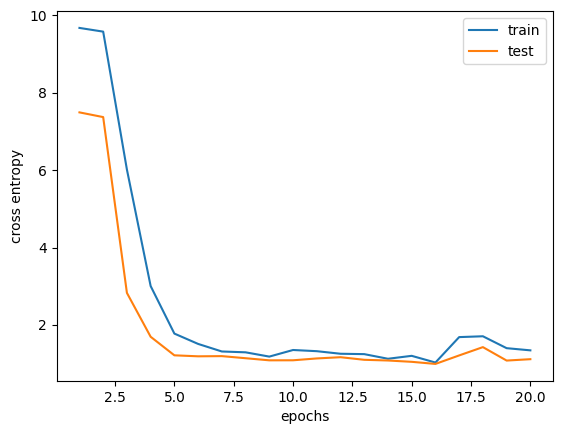

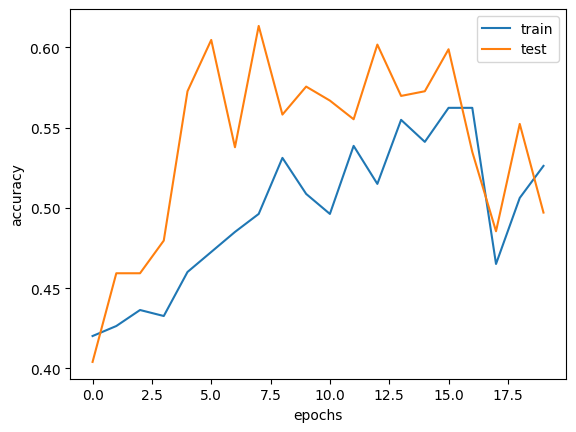

In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, num_epochs+1)

# plt.plot(epochs, train_loss, label="train")
# plt.plot(epochs, test_loss, label="test")
# plt.xlabel("epochs")
# plt.ylabel("cross entropy")
# plt.legend()
# plt.show()

# plt.plot(train_acc, label="train")
# plt.plot(test_acc, label="test")
# plt.xlabel("epochs")
# plt.ylabel("accuracy")
# plt.legend()
# plt.show()

In [ ]:
# How to increase accuracy

To streamlit

In [ ]:
# print(class_names)

['chinstrap_penguins', 'piplup', 'adelie_penguins', 'gentoo_penguins', 'miniso_penguins']


In [41]:
!pip install googledrivedownloader

In [42]:
%%writefile app.py

import streamlit as st
import requests
from google_drive_downloader import GoogleDriveDownloader

# Function to download .pth from Gdrive
def download_model_file(file_id, destination_path):
     gdd.download_file_from_google_drive(file_id=file_id, dest_path=destination_path)

# Define the file ID and local destination path for the .pth file on Google Drive
file_id = '1h4qKHVtwoUahBR25NKcZyW-PzQ7NeGn7'
destination_path = 'penguin_classifier.pth'

# Download the .pth file if not already downloaded
if not os.path.exists(destination_path):
    download_model_file(file_id, destination_path)

# Load the .pth file and use it as needed
model = load_model_from_pth(destination_path)

# Define class names
class_names = ['Chinstrap Penguins', 'Piplup', 'Adelie Penguins', 'Gentoo Penguins', 'Miniso Penguins']
class_to_index= {class_name: index for index, class_name in enumerate(class_names)}

# Define CNN model
class PenguinCNN(nn.Module):
    def __init__(self, num_classes):
        super(PenguinCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load the trained model
model = PenguinCNN(num_classes=len(class_names))
model.load_state_dict(torch.load(destination_path, map_location=torch.device('cpu')))
model.eval()

# Function to make predictions
def predict_species(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class_index = predicted.item()
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

# Streamlit app
def main():
    st.title('Penguin Image Classifier')
    uploaded_file = st.file_uploader('Upload an image of a penguin', type=['jpg', 'jpeg', 'png'])

    if uploaded_file is not None:
        st.image(uploaded_file, caption='Uploaded Image.', use_column_width=True)
        st.write('')
        st.write('Classifying...')

        # Make a prediction
        species = predict_species(uploaded_file)
        st.write(f'Prediction: {species}')

if __name__ == '__main__':
    main()


Overwriting app.py


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.198.214.206:8501

  Stopping...
  Stopping...


In [ ]:
# !npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/drive/MyDrive/colab_projects/penguin_classifier4/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/drive/MyDrive/colab_projects/penguin_classifier4/package.json'
npm WARN penguin_classifier4 No description
npm WARN penguin_classifier4 No repository field.
npm WARN penguin_classifier4 No README data
npm WARN penguin_classifier4 No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 3.177s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
# import urllib
# print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.126.84.70


In [ ]:
# !streamlit run app.py &>/content/logs.txt &

In [ ]:
# !npx localtunnel --port 8501

npx: installed 22 in 2.368s
your url is: https://heavy-emus-grin.loca.lt
^C
